In [1]:
import talk.config as con

%matplotlib inline

con.config_mosek()
con.config_matplotlib()
con.config_configManager()

Set MOSEKLM_LICENSE_FILE environment variable
Update ConfigManager


## Constrained regression

Let $\mathbf{A} \in \mathbb{R}^{n \times m}$ and $\mathbf{b} \in \mathbb{R}^n$. We solve the constrained least squares problem: 

\begin{align}\mathbf{x}^{*}=\arg\min_{\mathbf{x} \in \mathbb{R}^m}& \rVert{\mathbf{A}\mathbf{x}-\mathbf{b}}\lVert_2\\
\text{s.t. } &\Sigma\,x_i=1\\
            &\mathbf{x}\geq 0
\end{align}

## Examples:
- Tracking an index (index in $\mathbf{b}$, assets in $\mathbf{A}$)
- Constructing an indicator, factor analyis, ...
- Approximation...
- ...

Regression is the **Swiss army knife** of professional quant finance. 

## Thales of Miletus (c. 624 BC -  c. 546 BC). 
<img src="talk/thales.jpg" style="margin-left:auto; margin-right:auto; display:block">

## The normal equations

As we (probably) all know 

$$
\mathbf{x}^{*}=\left(\mathbf{A}^T \mathbf{A}\right)^{-1}\mathbf{A}^{T}\mathbf{x}
$$
solves
\begin{align}\mathbf{x}^{*}=\arg\min_{\mathbf{x} \in \mathbb{R}^m}& \rVert{\mathbf{A}\mathbf{x}-\mathbf{b}}\lVert_2
\end{align}
Almost there?

Shall we apply the sculptor method?
- We could delete the negative entries (really bad if they are all negative)
- We could scale the surviving entries to enforce the $\Sigma\,x_i=1$.

Done?

<div>
<img src="talk/cone.png" style="margin-left:auto; margin-right:auto; display:block">
$$y \geq \sqrt{x_1^2 + x_2^2}=\rVert{\mathbf{x}}\lVert_2$$
</div>

## Conic Programming

We introduce an auxiliary scalar $z$:
    
\begin{align}\min_{z \in \mathbb{R}, \mathbf{x} \in \mathbb{R}^m} & z\\
\text{s.t. }&z \geq \rVert{\mathbf{A}\mathbf{x}-\mathbf{b}}\lVert_2\\
            &\Sigma\,x_i=1\\
            &\mathbf{x}\geq 0
\end{align}


We introduce an auxiliary vector $\mathbf{y} \in \mathbb{R}^n$:

\begin{align}\min_{z \in \mathbb{R}, \mathbf{x} \in \mathbb{R}^m, \mathbf{y} \in \mathbb{R}^n} & z\\
\text{s.t. }&z \geq \rVert{y}\lVert_2\\
            &\mathbf{y} = \mathbf{A}\mathbf{x}-\mathbf{b}\\
            &\Sigma\,x_i=1\\
            &\mathbf{x}\geq 0
\end{align}

We **lifted** the problem from a $m$ dimensional space into a $m + n + 1$ dimensional space. 

Alternative notation: $$z \geq \rVert{y}\lVert_2 \,\Leftrightarrow\, [z,y] \in \mathcal{Q}_{n+1}$$

## Application: Implementing a minimum variance portfolio
The $i$th column of $\mathbf{R}$ is the time series of returns for the $i$th asset.
Hence to minimize the variance of a portfolio (a linear combination of assets) we solve:

\begin{align}\mathbf{w}^{*}=\arg\min_{\mathbf{w} \in \mathbb{R}^m}& \rVert{\mathbf{R}\mathbf{w}-\mathbf{0}}\lVert_2\\
\text{s.t. } &\Sigma\,w_i=1\\
            &\mathbf{w}\geq 0
\end{align}

**Attention**: This is strictly speaking not a Minimum Variance portfolio as we use squared deviations from $0$ rather than from the mean.  

In [2]:
from mosek.fusion import Expr, Domain, Model, DenseMatrix, ObjectiveSense
import numpy as np

def __two_norm(model, v):
    t = model.variable(1, Domain.greaterThan(0.0))
    model.constraint(Expr.vstack(t, v), Domain.inQCone())
    return t

def min_var(matrix, lamb=0.0):
    """
    min 2-norm (matrix*w) - lamb*2-norm(w)
    s.t. e'w = 1, w >= 0
    """
    # define model
    model = Model('lsqPos')
    
    # introduce non-negative weight variables
    w = model.variable("w", int(matrix.shape[1]), Domain.inRange(0.0, 1.0))
       
    # e'*w = 1
    model.constraint(Expr.sum(w), Domain.equalsTo(1.0))
    
    # introduce the cones
    z = __two_norm(model, Expr.mul(DenseMatrix(matrix), w))
    t = __two_norm(model, w)

    # minimization of the residual
    model.objective(ObjectiveSense.Minimize, Expr.add(z, Expr.mul(t, lamb)))
    model.solve()

    return np.array(w.level())

[ 0.6688288   0.19032354  0.08070414  0.0475149   0.0126286 ]


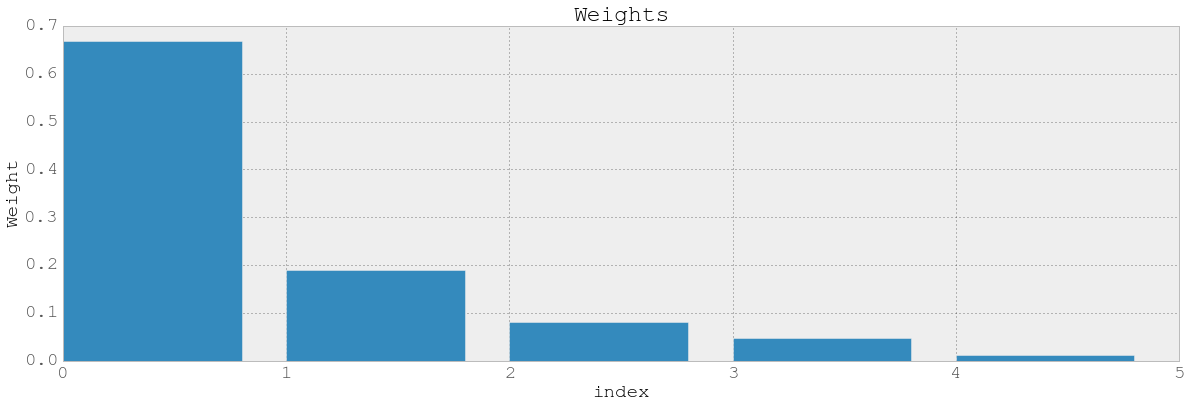

In [3]:
import numpy as np
import matplotlib.pyplot as plt
random_data = np.dot(np.random.randn(250,5), np.diag([1,2,3,4,5]))
data = min_var(random_data)
print(data)

plt.bar(range(0,5),data)
plt.ylabel("Weight"), plt.xlabel("index"), plt.title("Weights")
plt.show()

## Balance?

- Bounds
- **Tikhonov regularization** (penalty by the $2$-norm of the weights in the objective), also known as **Ridge Regression** or **Shrinkage to the mean**
 

\begin{align}\mathbf{w}^{*}=\arg\min_{\mathbf{w} \in \mathbb{R}^m}& \rVert{\mathbf{R}\mathbf{w}}\lVert_2 + \lambda \rVert{\mathbf{w}}\lVert_2\\
\text{s.t. } &\Sigma\,w_i=1\\
            &\mathbf{w}\geq 0
\end{align}

- The $1/N$ portfolio is the limit for $\lambda \to \infty$


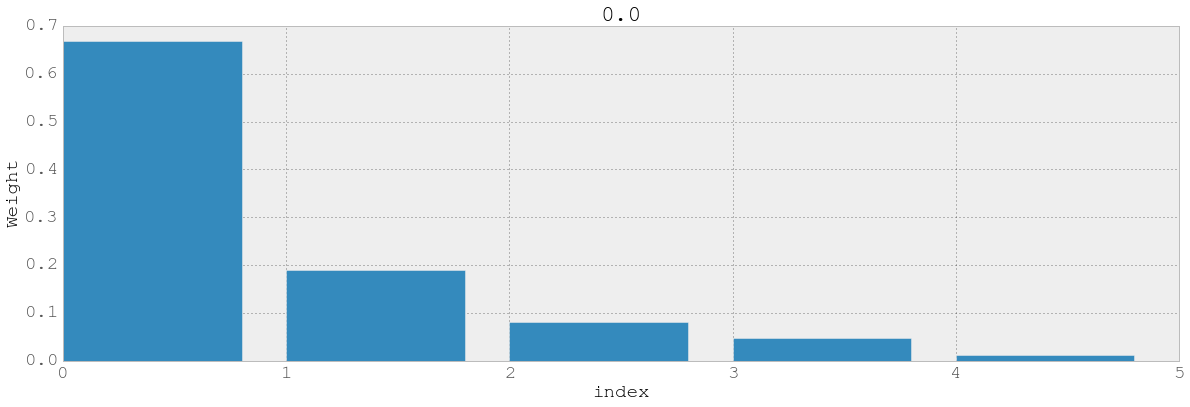

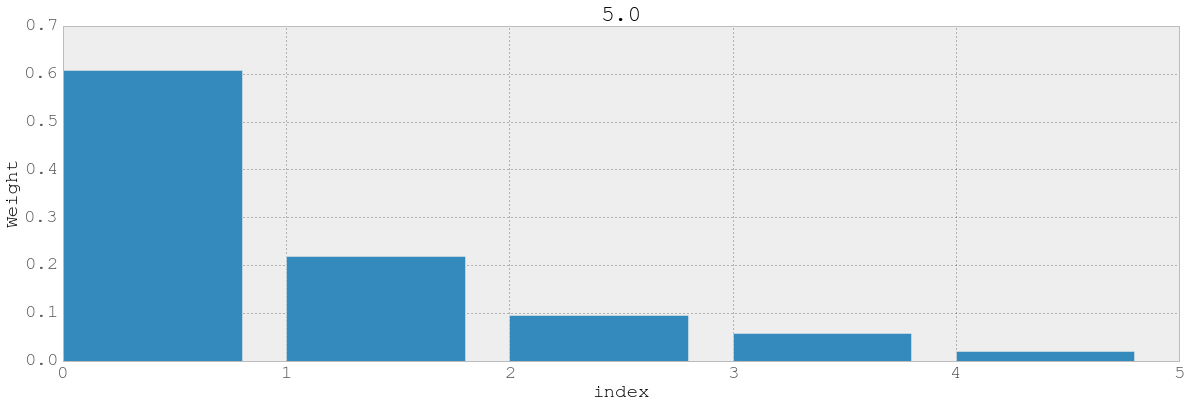

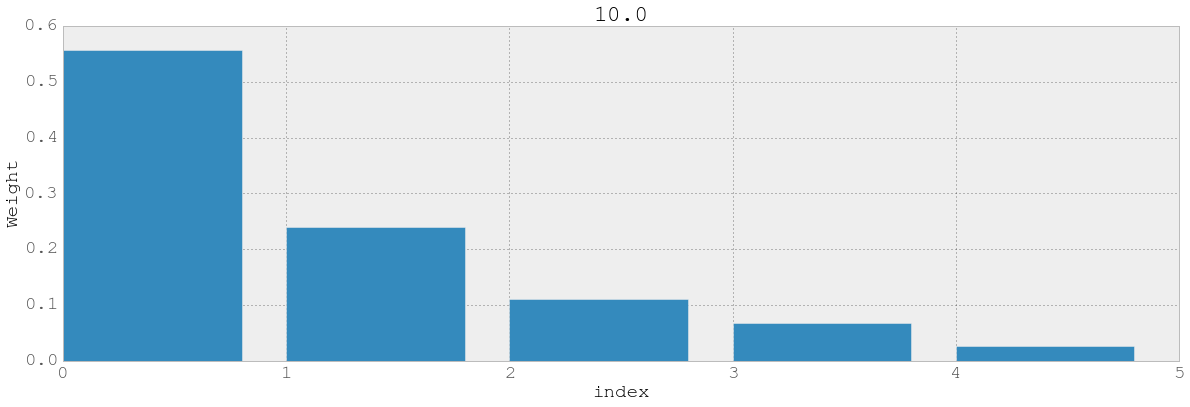

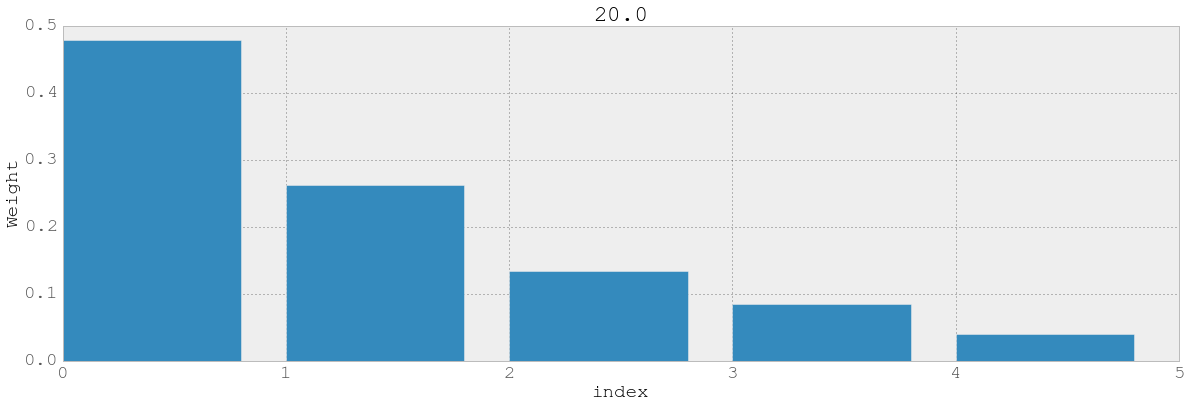

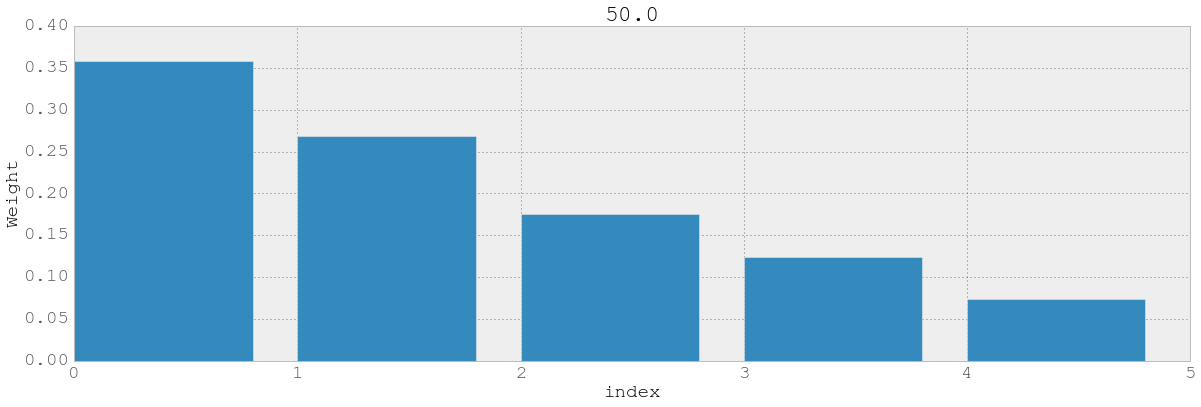

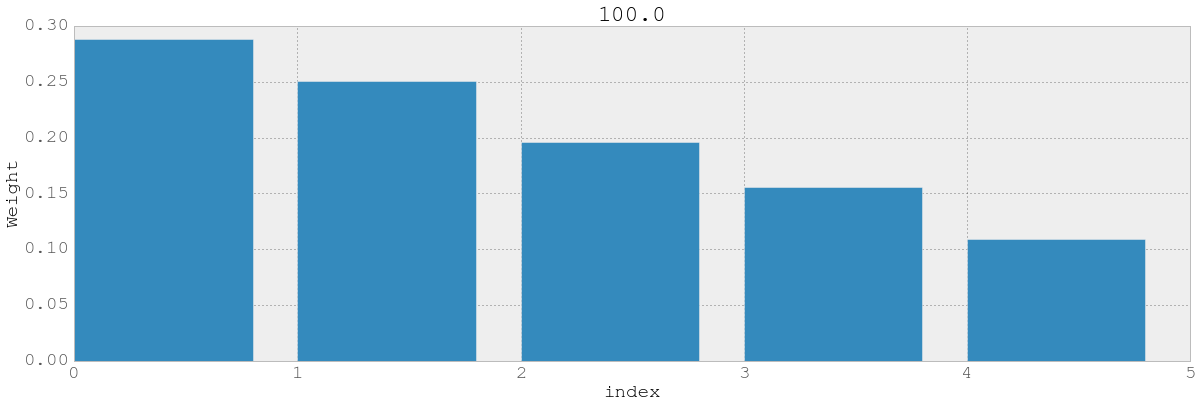

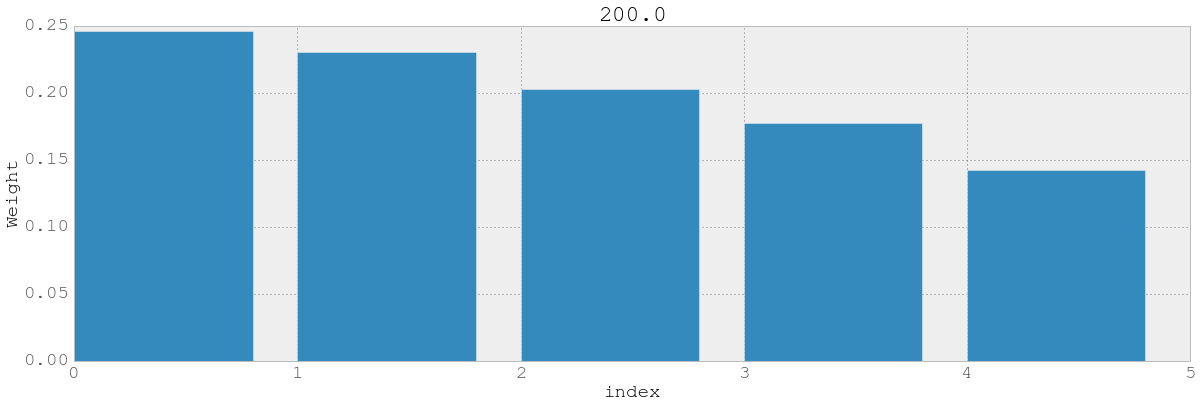

In [4]:
import matplotlib.pyplot as plt
for lamb in [0.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0]:
    data = min_var(random_data, lamb=lamb)
    plt.bar(range(0,5), data)
    plt.title(lamb), plt.ylabel("Weight"), plt.xlabel("index")
    plt.show()

## Summary

- We solve a constrained least squares problem by introducing $n + 1$ additional dimensions ($n$ is the number of rows is the problem).

- We introduce a quadratric cone living in those new dimensions.

- We construct a minimum variance portfolio.

- Using Tikhonov regularization we can interpolate between the Minimum Variance portfolio and the $1/N$ portfolio.

<a href=http://localhost:8888>Back to Overview</a>